In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

sys.path.append(os.path.abspath("../"))

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# import japanize_matplotlib
plt.style.use('ggplot')

import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import LogisticRegressionCV, LassoCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Chang (2020) 's simulation data
- The following uses the author's R code as is to generate data
- https://github.com/NengChiehChang/Diff-in-Diff/blob/master/Figure%202/Lasso_N200_P100.R

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R 
#Data generating #Repeated outcomes
set.seed(666)
B=1000
N=200
p=100
s=5
X=array(rnorm(N*B*p,0,1),dim=c(B,N,p))
gamma=c(s:1,rep(0,(p-s)))/s

D=matrix(0,B,N)
z=matrix(0,B,N)
pr=matrix(0,B,N)

for (i in 1:B){
  z[i,] = X[i,,]%*%gamma        # linear combination 
  pr[i,] = 1/(1+exp(-z[i,]))         # P(D=1 given X) Probit
  D[i,] = rbinom(N,1,pr[i,]) 
}


beta1=gamma+0.5
beta2=gamma+1
theta=3

e1=matrix(rnorm(B*N,0,0.1),B,N)
e2=matrix(rnorm(B*N,0,0.1),B,N)
e3=matrix(rnorm(B*N,0,0.1),B,N)

Y00=matrix(0,B,N)
Y01=matrix(0,B,N)
Y11=matrix(0,B,N)

for (i in 1:B){
  
  Y00[i,]=X[i,,]%*%beta1+e1[i,]
  Y01[i,]=Y00[i,]+1+e2[i,]
  Y11[i,]=theta+Y01[i,]+e3[i,]
}

Y0=Y00
Y1=Y01*(1-D)+Y11*D


In [4]:
%R -o Y0
%R -o Y1
%R -o D
%R -o X

In [5]:
# pd.DataFrame({"Y0": Y0}, index=range(len(Y0)))
B = 500
sim_df = {}
for i in range(B):
    _df = pd.DataFrame(
        {
            "Y0": Y0[i],
            "Y1": Y1[i],
            "D": D[i],
        }
    )
    _x = pd.DataFrame(X[i])
    _x = _x.add_prefix("x")
    _df = pd.concat([_df, _x], axis=1)

    sim_df[i] = _df
X_cols = _x.columns

In [6]:
 _df

,Y0,Y1,D,x0,x1,x2,x3,x4,x5,x6,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
0,-0.003602,0.970535,0.0,1.889988,-0.056027,-0.563268,-1.202132,0.591093,1.686063,-0.650799,...,-0.693243,-1.279765,-2.516965,-0.687328,-2.473922,-0.730057,-0.146384,1.607868,0.082292,-0.576736
1,-0.852637,3.173301,1.0,1.278091,0.982398,-1.136320,-0.928097,-0.499173,1.567385,-0.830486,...,-0.888568,0.900660,-0.254256,-0.925030,-0.385368,-0.786996,-1.747601,-1.850420,0.151457,-0.416914
2,4.747038,5.739913,0.0,0.226373,0.162901,-1.132363,0.852646,-1.371068,0.527713,-0.646944,...,-1.192920,1.063294,0.875597,0.711735,-1.525250,0.333650,1.104279,1.671706,0.436497,-0.252112
3,4.816329,8.798706,1.0,-0.998380,0.973315,0.392747,0.552135,1.182711,-1.234632,-1.078489,...,-1.131993,1.466303,0.819110,-0.656505,-0.911540,0.555605,0.503341,-0.116935,-1.547379,1.071759
4,-0.898693,0.211089,0.0,-0.614254,-0.448589,1.749870,1.581517,-0.842574,-0.164045,1.247309,...,1.535971,-1.388497,-1.679609,0.957741,-0.033490,-0.917054,-0.489183,-0.736029,-0.684815,-0.061546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-1.959498,-1.056939,0.0,-0.868289,1.329060,-0.590168,0.732663,-0.364152,-0.373921,-0.949359,...,0.064505,0.618125,-0.431178,1.396596,2.266018,-0.126677,-1.215428,-1.770401,-1.204089,-0.704112
196,-4.550103,-3.635530,0.0,-1.566403,0.040015,1.580709,-0.875525,0.485187,0.109065,0.696657,...,-1.590324,-1.283542,1.286892,0.544436,-1.707202,1.183280,0.030452,-2.419513,-0.874370,0.145441
197,3.727522,4.913303,0.0,-0.529098,0.221729,-0.232709,-1.869121,-0.163331,-0.388734,0.339943,...,-1.430753,-0.680601,0.505378,-0.381764,-2.378419,-1.619236,1.381487,-0.093237,-1.038713,0.101041
198,-2.183669,-1.008014,0.0,0.454621,0.271726,-0.797086,-0.535868,-0.830360,-0.223316,-0.448468,...,0.966245,1.581590,0.076982,-0.519367,-0.145741,0.144435,0.581053,-0.357406,0.557944,0.210118


In [7]:
def naive_did(df) -> np.float:
    _pivot = df.groupby("D")[["Y0", "Y1"]].mean()
    _pivot["diff"] = _pivot.diff(axis=1)["Y1"]
    return _pivot["diff"].diff().values[-1]

In [8]:
naive_did_result = []
for i in tqdm(range(B)):
    naive_did_result.append(naive_did(sim_df[i]))

100%|██████████| 500/500 [00:02<00:00, 223.66it/s]


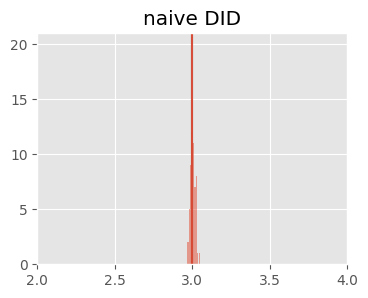

In [9]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(4,3))
ax.hist(naive_did_result, bins=100, alpha=0.5)
ax.set_xlim(2,4)
ax.set_title("naive DID")
ax.axvline(x=3, alpha=0.5, color = "black")
ax.axvline(x=np.mean(naive_did_result), alpha=0.9)
plt.show()

In [10]:
def semiparametricDID(
    df,
    y1_col,
    y0_col,
    d_col,
    X_cols,
    ps_model=LogisticRegressionCV(cv=5, random_state=333, penalty="l1", solver="saga"),
) -> np.float:

    ps_model.fit(df[X_cols], df[d_col])
    eps = 0.03
    ghat = np.clip(
        ps_model.predict_proba(df[X_cols])[:, 1],
        eps,
        1 - eps,
    )
    
    mean_d = df[d_col].mean()
    return (
        (df[y1_col] - df[y0_col]) / mean_d * (df[d_col] - ghat) / (1 - ghat)
    ).mean()

In [11]:
def dmldid_rc(
    df, y1_col, y0_col, d_col, X_cols,
    ps_model=LogisticRegressionCV(cv=5, random_state=333, penalty="l1", solver="saga"),
    l1k_model=LassoCV(cv=5, random_state=333),
) -> np.float:
    """
    [input]
    - df : pd.DataFrame
    - y1_col : str column name of post-outcome
    - y0_col : str column name of pre-outcome
    - X_cols : list column names of covariates
    - ps_model : model for propensity socore
    - l1k_model : model for outcome model
    [returen]
    - estimated ATT
    """

    K = 2
    df_set = train_test_split(df, random_state=0, test_size=0.5)
    thetabar = []
    for i in range(K):
        k = 0 if i == 0 else 1
        c = 1 if i == 0 else 0

        ps_model.fit(df_set[c][X_cols], df_set[c][d_col])

        eps = 0.03
        ghat = np.clip(
            ps_model.predict_proba(df_set[k][X_cols])[:, 1],
            eps,
            1 - eps,
        )

        control_y0 = df_set[c].query(f"{d_col} < 1")[y0_col]
        control_y1 = df_set[c].query(f"{d_col} < 1")[y1_col]
        _y = control_y1 - control_y0
        control_x = df_set[c].query(f"{d_col} < 1")[X_cols]

        l1k_model.fit(control_x, _y)
        l1hat = l1k_model.predict(df_set[k][X_cols])

        p_hat = df_set[c][d_col].mean()

        _e = (
            (df_set[k][y1_col] - df_set[k][y0_col])
            / p_hat
            * (df_set[k][d_col] - ghat)
            / (1 - ghat)
            - (df_set[k][d_col] - ghat) / p_hat / (1 - ghat) * l1hat
        ).mean()

        thetabar.append(_e)
    return np.mean(thetabar)

In [12]:
semiparametricDID(
    sim_df[0],
    "Y1",
    "Y0",
    "D",
    X_cols,
    ps_model=LGBMClassifier(max_depth=10, random_state=0),
)

3.962089332918755

In [13]:
dmldid_rc(
    sim_df[0],
    "Y1",
    "Y0",
    "D",
    X_cols,
    ps_model=LGBMClassifier(max_depth=10, random_state=0),
    l1k_model=LGBMRegressor(max_depth=10, random_state=0),
)

2.9765030025738106

In [14]:
dmldid_lasso = []
abadie_lasso = []
dmldid_lgbm = []
abadie_lgbm = []
dmldid_rf = []
abadie_rf = []

In [15]:
for i in tqdm(range(B)):
    # lasso
    abadie_lasso.append(semiparametricDID(sim_df[i], "Y1", "Y0", "D", X_cols))
    dmldid_lasso.append(dmldid_rc(sim_df[i], "Y1", "Y0", "D", X_cols))

    # lgbm
    abadie_lgbm.append(
        semiparametricDID(
            sim_df[i],
            "Y1",
            "Y0",
            "D",
            X_cols,
            ps_model=LGBMClassifier(max_depth=10, random_state=0),
        )
    )
    dmldid_lgbm.append(
        dmldid_rc(
            sim_df[i],
            "Y1",
            "Y0",
            "D",
            X_cols,
            ps_model=LGBMClassifier(max_depth=10, random_state=0),
            l1k_model=LGBMRegressor(max_depth=10, random_state=0),
        )
    )
    
    #rf
    abadie_rf.append(
        semiparametricDID(
            sim_df[i],
            "Y1",
            "Y0",
            "D",
            X_cols,
            ps_model=RandomForestClassifier(max_depth=10, random_state=0),
        )
    )
    dmldid_rf.append(
        dmldid_rc(
            sim_df[i],
            "Y1",
            "Y0",
            "D",
            X_cols,
            ps_model=RandomForestClassifier(max_depth=10, random_state=0),
            l1k_model=RandomForestRegressor(max_depth=10, random_state=0)
        )
    )

100%|██████████| 500/500 [31:03<00:00,  3.73s/it]


In [16]:
result_df = pd.DataFrame(
    {
        "abadie_lasso": abadie_lasso,
        "dmldid_lasso": dmldid_lasso,
        "abadie_lgbm": abadie_lgbm,
        "dmldid_lgbm": dmldid_lgbm,
        "abadie_rf": abadie_rf,
        "dmldid_rf": dmldid_rf,
    }
)

In [17]:
result_df.describe()

,abadie_lasso,dmldid_lasso,abadie_lgbm,dmldid_lgbm,abadie_rf,dmldid_rf
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,3.390442,3.031536,3.965642,3.025750,3.783012,3.029856
std,0.222467,0.106967,0.013892,0.079726,0.019756,0.046813
min,3.035349,2.625763,3.902150,2.839551,3.724768,2.958022
25%,3.151071,2.981631,3.956542,2.973501,3.768349,2.998804
50%,3.445013,3.028662,3.965470,3.020729,3.782012,3.018560
75%,3.543231,3.086449,3.975072,3.071821,3.797080,3.044719
max,3.957543,3.581170,4.022072,3.320429,3.859996,3.378559


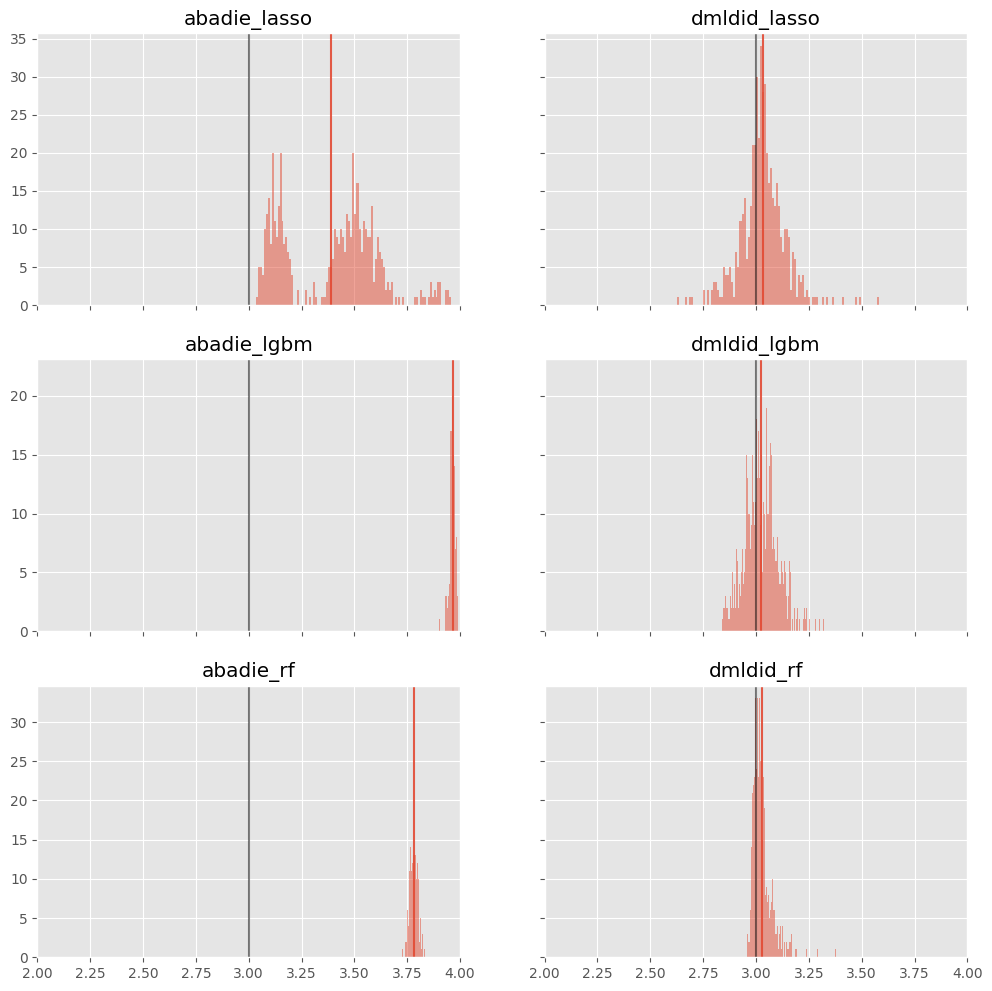

In [18]:
fig, ax = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(12,12))
ax = ax.ravel() 
for i, _col in enumerate(result_df.columns):
    ax[i].hist(result_df[_col], bins=100, alpha=0.5)
    ax[i].set_xlim(2,4)
    ax[i].set_title(_col)
    ax[i].axvline(x=3, alpha=0.5, color = "black")
    ax[i].axvline(x=result_df[_col].mean(), alpha=0.9)
plt.show()

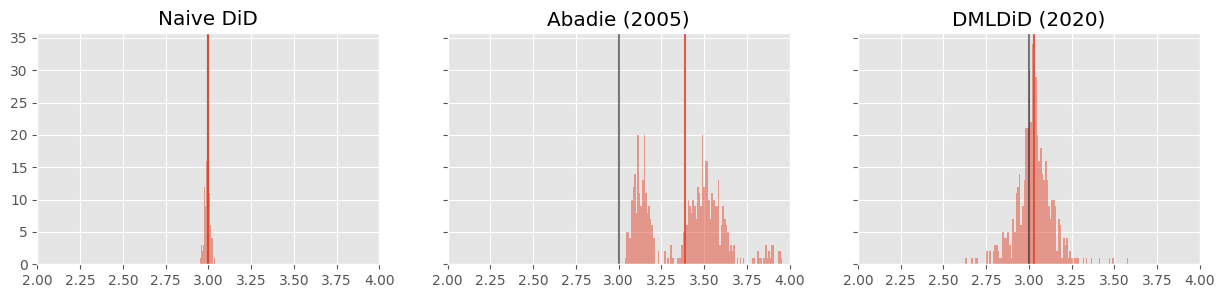

In [19]:
_label = ["Naive DiD", "Abadie (2005)", "DMLDiD (2020)"]
result_df = pd.DataFrame(
    {
        "naive_did":naive_did_result,
        "abadie_lasso": abadie_lasso,
        "dmldid_lasso": dmldid_lasso,    
    }
)
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,3))
ax = ax.ravel() 
for i, _col in enumerate(result_df.columns):
    ax[i].hist(result_df[_col], bins=100, alpha=0.5)
    ax[i].set_xlim(2,4)
    ax[i].set_title(_label[i])
    ax[i].axvline(x=3, alpha=0.5, color = "black")
    ax[i].axvline(x=result_df[_col].mean(), alpha=0.9)
plt.show()